Thermomechanical convection regimes with viscoplastic rheology
=======

This notebook models the convection regimes with viscoplatic rheology as outlined in Moresi and Solomatov (1998). We solve the system of equations,
$$-\nabla \cdot \left( \eta \dot\varepsilon \right) + \nabla p = \Delta \rho g \mathbf{\hat z}$$
and, 
$$\nabla \cdot \mathbf{v} = 0 $$
where $\dot\varepsilon = \nabla v + (\nabla v)^T$.

The rheology is implemented as outlined in Eqs. 6-14 in Moresi et al. (1998).


**Keywords:** particle swarms, Stokes system, advective diffusive systems

**References**

Louis Moresi and Viatcheslav Solomatov, Mantle convection with a brittle lithosphere: thoughts on the global tectonic styles of the Earth and Venus. Geophys. J. Int. (1998) 133 (3): 669-682.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import underworld as uw
import math
from underworld import function as fn
import glucifer
import time

/Users/glwu/underworld/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Setup parameters
-----


In [2]:
dim = 2
boxLength = 1.0
boxHeight = 1.0
tempMin = 0.0
tempMax = 1.0
# Set the resolution
res = 64
# Set the Rayleigh number
Ra=1e7

**Set input and output paths**

In [3]:
inputPath  = 'input/'
outputPath = 'output/'
# Make output directory if necessary
if uw.rank()==0:
    import os
    if not os.path.exists(outputPath):
        os.makedirs(outputPath)

Create mesh and finite element variables
------

In this case the mesh type used is different. For more information on the different mesh types see the user guide.

In [4]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q2/dPc1"), 
                                 elementRes  = (res, res), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (boxLength, boxHeight) )
 
velocityField    = uw.mesh.MeshVariable( mesh=mesh,    nodeDofCount=dim )
pressureField    = uw.mesh.MeshVariable( mesh=mesh.subMesh,    nodeDofCount=1 )
temperatureField = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=1 )
tempDotField     = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=1 )

Set initial and boundary conditions
----------

In [5]:
LoadFromFile = False

In [6]:
if(LoadFromFile == True):
# set up mesh for 32*32 data file; Note that this input is for stagnant lid mode
    mesh32 = uw.mesh.FeMesh_Cartesian( elementType = ("Q2/dPc1"), 
                                               elementRes = (32, 32), 
                                                 minCoord = (0., 0.), 
                                                 maxCoord = (boxLength, boxHeight)  )
    temperatureField32 = uw.mesh.MeshVariable( mesh=mesh32,         nodeDofCount=1 )
    pressureField32    = uw.mesh.MeshVariable( mesh=mesh32.subMesh, nodeDofCount=1 )
    velocityField32    = uw.mesh.MeshVariable( mesh=mesh32,         nodeDofCount=dim )

    temperatureField32.load(inputPath+'thermomechanical_convection_32_T.inp')
    velocityField32.load(inputPath+'thermomechanical_convection_32_v.inp')
    pressureField32.load(inputPath+'thermomechanical_convection_32_P.inp')
    
    temperatureField.data[:] = temperatureField32.evaluate(mesh)
    pressureField.data[:] = pressureField32.evaluate(mesh.subMesh)
    velocityField.data[:] = velocityField32.evaluate(mesh)
    # load summary statistics into arrays
    data = np.loadtxt(inputPath+'thermomechanical_convection_sumary.txt', unpack=True )
    timeVal, vrmsVal, nuVal = data[0].tolist(), data[1].tolist(), data[2].tolist()

The initial temperature is critical for a simulation to see desired behavior. To reproduce Fig 3 in Moresi and Solomatov (1998), initial temperature condition must be known, otherwise it is impossible to reproduce it.

Note that this set up is reasonably comparable to the Earth, but assuming constant geothermal gradient in the lithosphere, and constant adiabatic gradient for the upper and lower mantle.

In [7]:
if(LoadFromFile == False):
    velocityField.data[:] = [0.,0.]
    pressureField.data[:] = 0.
    temperatureField.data[:] = 0.
    pertStrength = 0.05
    refLithTemperature = 0.56 # choose higher value for more vilent convection
    deltaTemp = tempMax - tempMin
    for index, coord in enumerate(mesh.data):
        if coord[1] > 0.965:
            temperatureField.data[index] = refLithTemperature - refLithTemperature * (coord[1] - 0.965)/0.035
        else:
            temperatureField.data[index] = refLithTemperature - (1.-refLithTemperature) * (coord[1] - 0.965)/0.965
        pertCoeff = math.cos( math.pi * coord[0]/boxLength ) * math.sin( math.pi * coord[1]/boxLength )
        temperatureField.data[index] += tempMin + pertStrength * pertCoeff # + deltaTemp*(boxHeight - coord[1])
        temperatureField.data[index] = max(tempMin, min(tempMax, temperatureField.data[index]))
    # initialise summary statistics arrays
    timeVal = []
    vrmsVal = []
    nuVal = []

**Boundary conditions**

This step is to ensure that the temperature boundary conditions are satisfied, as the initial conditions above may have been set to different values on the boundaries.

In [8]:
for index in mesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = tempMax
for index in mesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = tempMin

**Set boundary conditions for stokes system and advection-diffusion equation**

Construct sets for the both horizontal and vertical walls. Combine the sets of vertices to make the I (left and right side walls) and J (top and bottom walls) sets. Note that both sets contain the corners of the box.

In [9]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
allWalls = iWalls + jWalls

freeSlipBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                               indexSetsPerDof = (iWalls,jWalls) )
tempBC     = uw.conditions.DirichletCondition( variable      = temperatureField, 
                                               indexSetsPerDof = (jWalls,) )

**Plot initial conditions**

Automatically scale the size of the vector arrows for the velocity field maximum.


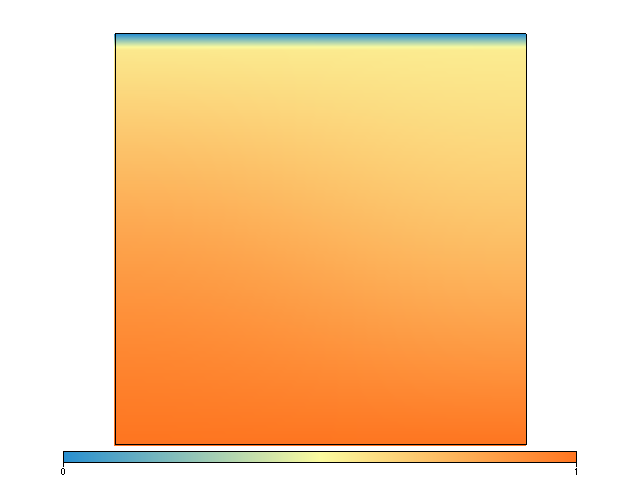

In [10]:
velmax = np.amax(velocityField.data[:])
if(velmax==0.0):
    velmax = 1.0
figtemp = glucifer.Figure()
tempminmax = fn.view.min_max(temperatureField)
figtemp.append( glucifer.objects.Surface(mesh, tempminmax) )
figtemp.append( glucifer.objects.VectorArrows(mesh, velocityField, scaling=0.1/velmax, arrowHead=0.2 ) )
figtemp.show()

Set up rheology and buoyancy functions
-----

In [11]:
# Rheology See Eqs. 6-14 in Moresi et al. (1998)
eta0 = 3.333333e-5
activationEnergy = 20.617905321288585 # 24.01910270295074 #27.63102112

tao0 = 1e5 # also test 4e5, 1e6
tao1 = 1e7

# calculate second invariant of strain rate
strainRateFn              = fn.tensor.symmetric( velocityField.fn_gradient )
strainRate_2ndInvariantFn = fn.tensor.second_invariant(strainRateFn)

eta_vis = eta0 * fn.math.exp( activationEnergy / (temperatureField + 1.))
eta_plastic = (tao0 + tao1 * (1. - fn.coord()[1]))/(strainRate_2ndInvariantFn + 1e-8)

fn_viscosity = fn.misc.min(eta_vis, eta_plastic)

densityFn = Ra*temperatureField
# Define our vertical unit vector using a python tuple (this will be automatically converted to a function)
z_hat = ( 0.0, 1.0 )
# Now create a buoyancy force fn using the density.
buoyancyFn = z_hat*densityFn

**Plot the viscosity**



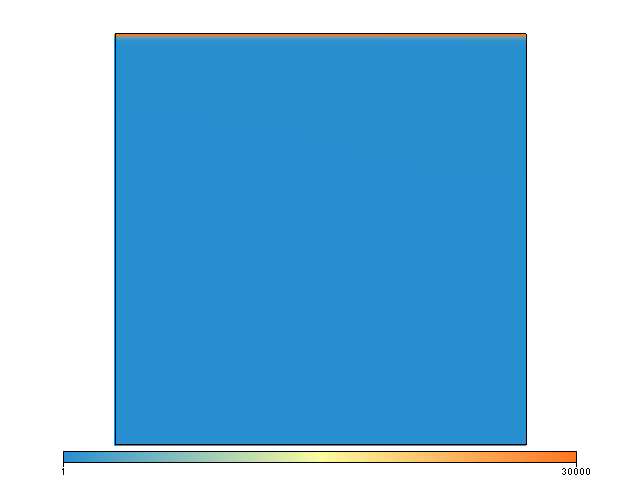

In [12]:
figEta = glucifer.Figure()
figEta.append( glucifer.objects.Surface(mesh, fn_viscosity) )
figEta.show()

System setup
-----

**Setup the Stokes system**

In [13]:
stokes = uw.systems.Stokes(velocityField=velocityField, 
                              pressureField=pressureField,
                              conditions=[freeSlipBC,],
                              fn_viscosity=fn.exception.SafeMaths(fn_viscosity), 
                              fn_bodyforce=buoyancyFn )

solver=uw.systems.Solver(stokes)

# options.scr to set options for pressure solve; set_inner_method for velocity solve
if (uw.nProcs() == 1):
    solver.set_inner_method('lu')
    #stokesSolver.set_penalty(1e6)
    #stokesSolver.options.scr.ksp_rtol = 1e-5
else:
    solver.set_inner_method('mumps')
    solver.set_penalty(1e6)            # large penalty can be used for mumps but not for mg
    solver.options.scr.ksp_type = 'cg' #
    #stokesSolver.options.scr.pc_type = 'jacobi' #
    # stokesSolver.options.scr.ksp_rtol = 1e-5

**Set up the advection-diffusion system**

In [14]:
advDiff = uw.systems.AdvectionDiffusion( temperatureField, 
                                        tempDotField,
                                        velocityField,
                                        fn_diffusivity=1.,
                                        conditions=[tempBC,],
                                        _allow_non_q1=True )

/Users/glwu/underworld/underworld/systems/_advectiondiffusion.py:71: RuntimeWarning: The 'phiField' is discretised on a Q2 mesh. This 'uw.system.AdvectionDiffusion' implementation is only stable for a phiField discretised with a Q1 mesh. Either create a Q1 mesh for the 'phiField' or, if you know what you're doing, override this error with the argument '_allow_non_q1=True' in the constructor
  "what you're doing, override this error with the argument '_allow_non_q1=True' in the constructor", category=RuntimeWarning)


Analysis tools
-----

**Nusselt number**


In [15]:
def FindNusseltNumber(temperatureField, linearMesh, xmax, zmax):
    tempgradField = temperatureField.fn_gradient
    vertGradField = tempgradField[1]
    BottomInt = 0.0
    GradValues = temperatureField.fn_gradient[1].evaluate(mesh.specialSets["MaxJ_VertexSet"])
    TopInt = sum(GradValues)
    for index in mesh.specialSets["MinJ_VertexSet"]:
        BottomInt += temperatureField.data[index]
    Nu = -zmax*TopInt/BottomInt
    return Nu[0]

Main simulation loop
-----

In [16]:
steps_prev = len(timeVal)
steps = 0
steps_end = 100
step_out = 10

# Set time to zero, unless we are loading from file.
try:
    time_start = timeVal[-1]
except:
    time_start = 0.0

if(uw.rank()==0):
    print 'Begining at t = ',time_start,' after having completed ',steps_prev,' steps'

simtime = time_start

# Save mesh and retain file handle for future xdmf creation
meshFileHandle = mesh.save(outputPath+"Mesh.h5")

Begining at t =  0.0  after having completed  0  steps


In [17]:
# Setup clock to calculate simulation CPU time
start = time.clock()

# Perform steps_end steps
rms_v, nu_no = 0.0, 0.0
while steps < steps_end:
    # Get solution for initial configuration
    solver.solve(nonLinearIterate=False)
    # Retrieve the maximum possible timestep for the AD system
    dt = advDiff.get_max_dt()
    if steps == 0:
        dt = 0.
    # Advect using this timestep size
    advDiff.integrate(dt)
    
    # Calculate the RMS velocity
    rms_v = stokes.velocity_rms()
    nu_no = FindNusseltNumber(temperatureField, mesh, boxLength, boxHeight)
    
    vrmsVal.append(rms_v)
    nuVal.append(nu_no)
    timeVal.append(simtime)
    
    if(uw.rank()==0):
        with open(outputPath+'/FrequentOutput.dat','ab') as f:
            np.savetxt(f, np.column_stack((simtime, rms_v, nu_no)), fmt='%.8e')
                   
    if steps == 0 or steps % step_out == 0:
        if(uw.rank()==0):
            print "steps = {:04d}; time = {:.6e}; vrms = {:6.2f}; nusselt = {:6.4f}; CPU = {:4.1f}s".format(
               steps, simtime, rms_v, nu_no, time.clock()-start)
        
        filename = outputPath+"/velocityField."+str(steps)
        vFH      = velocityField.save(filename+".h5")
        velocityField.xdmf( filename, vFH, "velocity", meshFileHandle, "Mesh", simtime )
        
        filename = outputPath+"/temperatureField."+str(steps)
        TFH      = temperatureField.save(filename+".h5")
        velocityField.xdmf( filename, TFH, "temperature", meshFileHandle, "Mesh", simtime )
        
    # Increment time and store results
    simtime += dt
    steps += 1

nu_no = FindNusseltNumber(temperatureField, mesh, boxLength, boxHeight)

if(uw.rank()==0):
    print "steps = {:04d}; time = {:.6e}; vrms = {:6.2f}; nusselt = {:6.4f}; CPU = {:4.1f}s".format(
               steps, simtime, rms_v, nu_no, time.clock()-start)

steps = 0000; time = 0.000000e+00; vrms = 1370.25; nusselt = 16.0000; CPU =  2.3s
steps = 0010; time = 9.311716e-06; vrms = 1869.75; nusselt = 16.0178; CPU = 24.8s
steps = 0020; time = 1.767430e-05; vrms = 2235.91; nusselt = 16.0331; CPU = 47.6s
steps = 0030; time = 2.474977e-05; vrms = 2595.61; nusselt = 16.0713; CPU = 69.6s
steps = 0040; time = 3.090479e-05; vrms = 2949.66; nusselt = 16.1298; CPU = 92.4s
steps = 0050; time = 3.637221e-05; vrms = 3295.08; nusselt = 16.2068; CPU = 115.4s
steps = 0060; time = 4.131059e-05; vrms = 3631.41; nusselt = 16.3019; CPU = 138.1s
steps = 0070; time = 4.583264e-05; vrms = 3956.56; nusselt = 16.4160; CPU = 161.3s
steps = 0080; time = 5.002119e-05; vrms = 4270.98; nusselt = 16.5506; CPU = 184.5s
steps = 0090; time = 5.393960e-05; vrms = 4571.45; nusselt = 16.7076; CPU = 207.8s
steps = 0100; time = 5.763750e-05; vrms = 4830.94; nusselt = 16.8698; CPU = 228.6s


Post simulation analysis
-----

**Check CPU timing**

Output timing for calculation per simulation time step

In [18]:
if(steps!=steps_prev):
    avtime = (time.clock() - start)/float(steps)
else:
    avtime = 0.0

if(uw.rank()==0):
    print "Average time per timestep = ", avtime, " seconds over ", steps, " steps"

Average time per timestep =  2.28574989  seconds over  100  steps


**Save data to files**

Save system summary data; $v_{rms}$ and the Nusselt number against time.


In [19]:
np.savetxt( outputPath+'thermomechanical_convection_regimes.txt',
           np.c_[timeVal, vrmsVal, nuVal], header="Time, VRMS, Nusselt" )

**Plot temperature field with velocity vectors overlaid**


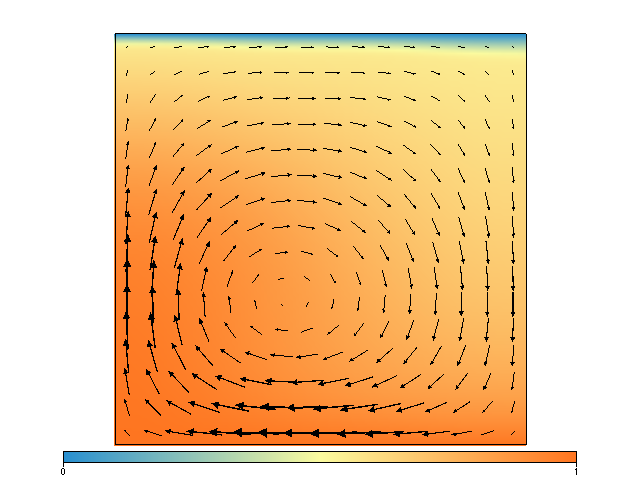

In [20]:
velmax = np.amax(velocityField.data[:])
figVT = glucifer.Figure()
figVT.append( glucifer.objects.Surface(mesh, temperatureField) )
figVT.append( glucifer.objects.VectorArrows(mesh, velocityField, scaling=0.1/velmax, arrowHead=0.2) )
figVT.show()

**Plot system summary information**

If the initial conditions were loaded up from a data file then these arrays will contain the saved data as well as results from the simulation just run.

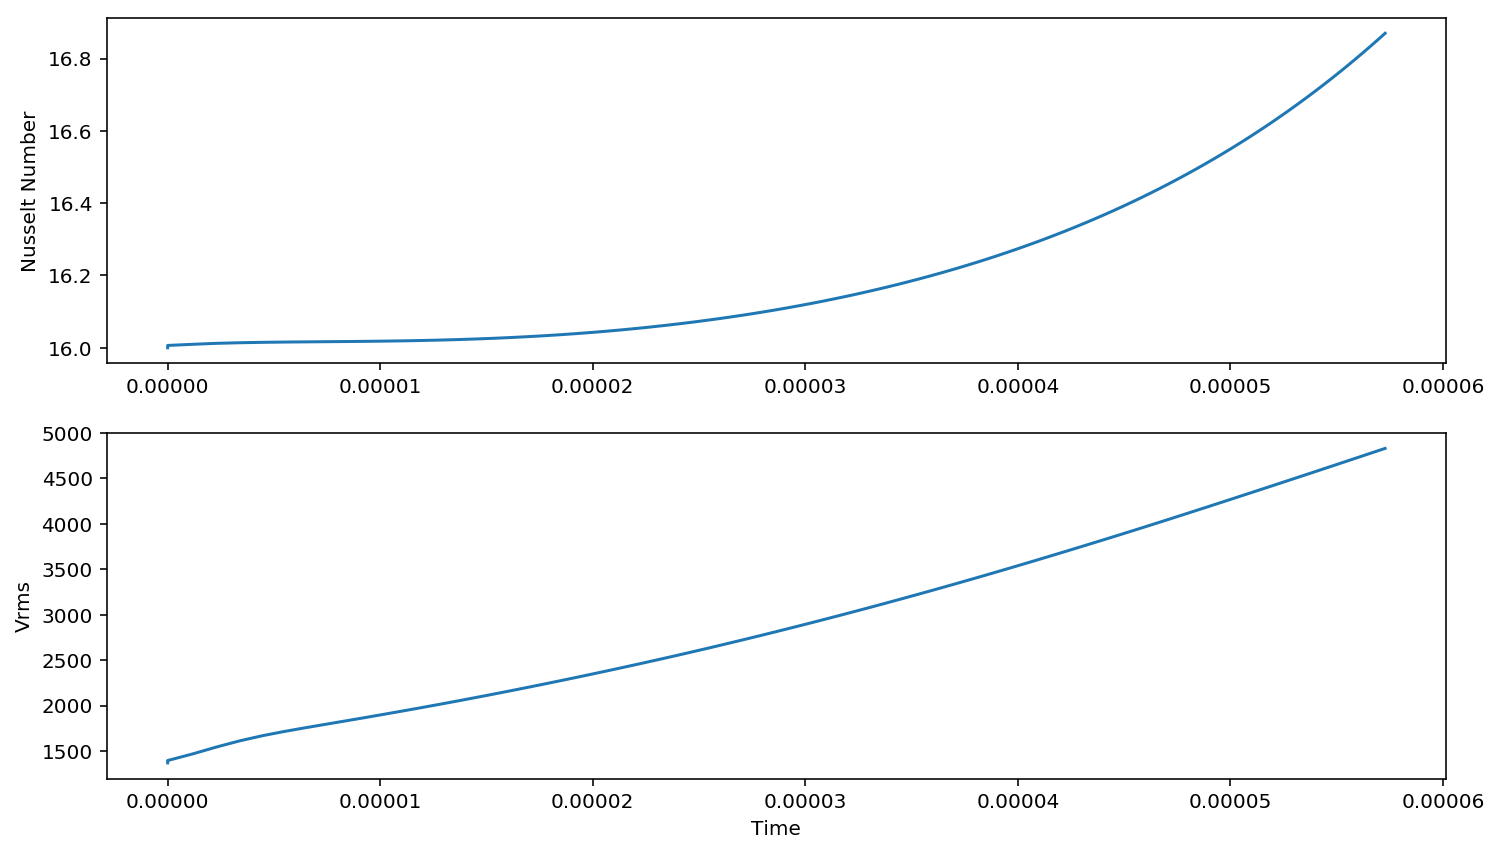

In [21]:
pylab.rcParams[ 'figure.figsize'] = 12, 7
plt.figure(1)
plt.subplot(211)
plt.plot(timeVal, nuVal)
plt.ylabel('Nusselt Number')

plt.subplot(212)
plt.plot(timeVal,vrmsVal)
plt.xlabel('Time')
plt.ylabel('Vrms')
plt.show()